# Module 14: Transformer Architecture

**Attention Is All You Need**

---

## 1. Objectives

- ✅ Understand Transformer architecture
- ✅ Implement multi-head attention
- ✅ Implement positional encoding
- ✅ Build complete Transformer from scratch

## 2. Prerequisites

- [Module 13: Attention Mechanism](../13_attention/13_attention.ipynb)

## 3. Transformer Overview

```
         Encoder                     Decoder
    ┌─────────────┐            ┌─────────────┐
    │   Self-     │            │   Masked    │
    │  Attention  │            │ Self-Attn   │
    ├─────────────┤            ├─────────────┤
    │  Add & Norm │            │ Add & Norm  │
    ├─────────────┤            ├─────────────┤
    │    FFN      │            │Cross-Attn   │←──
    ├─────────────┤            ├─────────────┤
    │  Add & Norm │            │ Add & Norm  │
    └─────────────┘            ├─────────────┤
           ↓                   │    FFN      │
      (to decoder)             ├─────────────┤
                               │ Add & Norm  │
                               └─────────────┘
```

### Key Innovations
- No recurrence → full parallelization
- Self-attention captures all pairwise relationships
- Positional encoding adds sequence order

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cpu


## 4. Positional Encoding

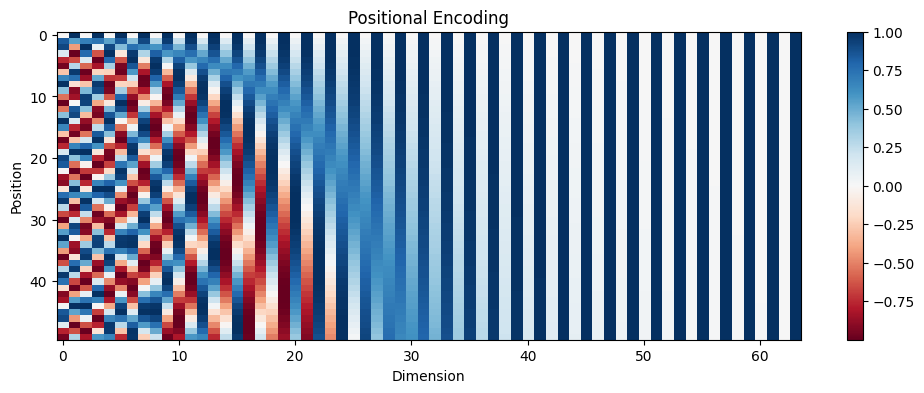

In [2]:
class PositionalEncoding(nn.Module):
    """Sinusoidal positional encoding."""

    def __init__(self, d_model, max_len=5000, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

        # Create positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()

        # div_term = 10000^(2i/d_model)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)  # Even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # Odd indices

        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: (batch, seq, d_model)
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

# Visualize
pe = PositionalEncoding(d_model=64)
plt.figure(figsize=(12, 4))
plt.imshow(pe.pe[0, :50, :].numpy(), aspect='auto', cmap='RdBu')
plt.xlabel('Dimension')
plt.ylabel('Position')
plt.title('Positional Encoding')
plt.colorbar()
plt.show()

## 5. Multi-Head Attention

In [3]:
class MultiHeadAttention(nn.Module):
    """Multi-head attention from scratch."""

    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, mask=None):
        """
        query, key, value: (batch, seq, d_model)
        mask: (batch, 1, seq) or (batch, seq, seq)
        """
        batch_size = query.size(0)

        # Linear projections
        Q = self.W_q(query)  # (batch, seq, d_model)
        K = self.W_k(key)
        V = self.W_v(value)

        # Split into heads: (batch, seq, d_model) -> (batch, heads, seq, d_k)
        Q = Q.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = K.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        # Scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))

        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Apply to values
        context = torch.matmul(attn_weights, V)  # (batch, heads, seq, d_k)

        # Concatenate heads: (batch, seq, d_model)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)

        return self.W_o(context), attn_weights

# Test
mha = MultiHeadAttention(d_model=512, num_heads=8)
x = torch.randn(2, 10, 512)
out, weights = mha(x, x, x)
print(f"MHA output: {out.shape}, weights: {weights.shape}")

MHA output: torch.Size([2, 10, 512]), weights: torch.Size([2, 8, 10, 10])


## 6. Feed-Forward Network

In [4]:
class FeedForward(nn.Module):
    """Position-wise feed-forward network."""

    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.fc2(self.dropout(F.relu(self.fc1(x))))

# Test
ffn = FeedForward(512, 2048)
out = ffn(x)
print(f"FFN output: {out.shape}")

FFN output: torch.Size([2, 10, 512])


## 7. Encoder Layer

In [5]:
class EncoderLayer(nn.Module):
    """Single Transformer encoder layer."""

    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.ffn = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Self-attention with residual
        attn_out, _ = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_out))

        # FFN with residual
        ffn_out = self.ffn(x)
        x = self.norm2(x + self.dropout(ffn_out))

        return x

# Test
encoder_layer = EncoderLayer(512, 8, 2048)
out = encoder_layer(x)
print(f"Encoder layer output: {out.shape}")

Encoder layer output: torch.Size([2, 10, 512])


## 8. Decoder Layer

In [6]:
class DecoderLayer(nn.Module):
    """Single Transformer decoder layer."""

    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.cross_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.ffn = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, encoder_out, src_mask=None, tgt_mask=None):
        # Masked self-attention
        attn_out, _ = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_out))

        # Cross-attention to encoder
        attn_out, _ = self.cross_attn(x, encoder_out, encoder_out, src_mask)
        x = self.norm2(x + self.dropout(attn_out))

        # FFN
        ffn_out = self.ffn(x)
        x = self.norm3(x + self.dropout(ffn_out))

        return x

## 9. Full Transformer

In [7]:
class Transformer(nn.Module):
    """Complete Transformer from scratch."""

    def __init__(self, src_vocab, tgt_vocab, d_model=512, num_heads=8,
                 num_layers=6, d_ff=2048, dropout=0.1, max_len=5000):
        super().__init__()

        self.d_model = d_model

        # Embeddings
        self.src_embed = nn.Embedding(src_vocab, d_model)
        self.tgt_embed = nn.Embedding(tgt_vocab, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len, dropout)

        # Encoder & Decoder stacks
        self.encoder_layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        self.decoder_layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])

        # Output
        self.fc_out = nn.Linear(d_model, tgt_vocab)

    def generate_mask(self, src, tgt):
        """Generate source padding mask and target causal mask."""
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)  # (batch, 1, 1, src_len)

        tgt_len = tgt.size(1)
        tgt_mask = torch.tril(torch.ones(tgt_len, tgt_len)).bool().to(tgt.device)
        tgt_pad_mask = (tgt != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = tgt_mask & tgt_pad_mask

        return src_mask, tgt_mask

    def encode(self, src, src_mask):
        x = self.pos_encoding(self.src_embed(src) * math.sqrt(self.d_model))
        for layer in self.encoder_layers:
            x = layer(x, src_mask)
        return x

    def decode(self, tgt, encoder_out, src_mask, tgt_mask):
        x = self.pos_encoding(self.tgt_embed(tgt) * math.sqrt(self.d_model))
        for layer in self.decoder_layers:
            x = layer(x, encoder_out, src_mask, tgt_mask)
        return self.fc_out(x)

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        encoder_out = self.encode(src, src_mask)
        return self.decode(tgt, encoder_out, src_mask, tgt_mask)

# Test
transformer = Transformer(src_vocab=1000, tgt_vocab=1000, d_model=256, num_heads=4, num_layers=2)
src = torch.randint(1, 1000, (2, 10))
tgt = torch.randint(1, 1000, (2, 8))
out = transformer(src, tgt)
print(f"Transformer output: {out.shape}")
print(f"Parameters: {sum(p.numel() for p in transformer.parameters()):,}")

Transformer output: torch.Size([2, 8, 1000])
Parameters: 6,556,648


## 10. 🔥 Real-World Usage

### PyTorch Built-in
```python
# Use PyTorch's implementation
transformer = nn.Transformer(
    d_model=512, nhead=8, num_encoder_layers=6,
    num_decoder_layers=6, dim_feedforward=2048
)
```

### Transformer Variants

| Model | Architecture | Use Case |
|-------|--------------|----------|
| BERT | Encoder only | Understanding |
| GPT | Decoder only | Generation |
| T5, BART | Encoder-Decoder | Seq2Seq tasks |

## 11. Interview Questions

**Q1: Why use positional encoding?**
<details><summary>Answer</summary>

Self-attention is permutation-invariant. Without positional info, "cat chased dog" = "dog chased cat". Sinusoidal encoding adds position info without additional parameters.
</details>

**Q2: What is multi-head attention?**
<details><summary>Answer</summary>

Run attention multiple times in parallel with different learned projections. Each head can focus on different aspects (syntax, semantics, etc.). Outputs are concatenated.
</details>

**Q3: What is the causal mask in decoder?**
<details><summary>Answer</summary>

Prevents decoder from "cheating" by looking at future tokens. Position i can only attend to positions <= i. Implemented as lower triangular mask.
</details>

## 12. Summary

- **Positional encoding**: Sinusoidal, adds position info
- **Multi-head attention**: Multiple parallel attention heads
- **Encoder**: Self-attention + FFN, repeated N times
- **Decoder**: Masked self-attn + cross-attn + FFN
- **Residual + LayerNorm**: Around every sublayer

## 13. References

- [Attention Is All You Need (2017)](https://arxiv.org/abs/1706.03762)
- [The Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/)
- [The Annotated Transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html)

---
**Next:** [Module 15: BERT](../15_bert/15_bert.ipynb)